IMPORTS

In [77]:


#tabular data, reading in tables and different data manipulation 
import pandas as pd 
#linear algebra and different methods
import numpy as np 

#PLOTTING 
import seaborn as sns 
import matplotlib.pyplot as plt 


#creating z scores 

from scipy.stats import zscore 



#Machine Learning 
#preprocessing (scaling data) 
from sklearn.preprocessing import StandardScaler

#model to use 
from sklearn.linear_model import LogisticRegression 
#train test split the data 
from sklearn.model_selection import train_test_split 

#first, lets fit an logistic regression model and assess performance

from sklearn.metrics import classification_report, confusion_matrix


Import and Clean

In [78]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/2023-usticc-dataset-classification/majors-list.csv
/kaggle/input/2023-usticc-dataset-classification/ACS_Survey_Subset.csv
/kaggle/input/2023-usticc-dataset-classification/Alumni.csv


In [79]:
import os

dfs = []


for dirname, _, filenames in os.walk('/kaggle/input'):

    for filename in filenames:

        file = os.path.join(dirname, filename)

        df = pd.read_csv(file).infer_objects()

        dfs.append(df)

In [80]:
#read in data 


#majors list data 
maj = dfs[0]
#acs data 
acs = dfs[1] 
#alumni data 
alum = dfs[2]

In [81]:
#inspect acs dataframe


acs.describe()

acs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8788 entries, 0 to 8787
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   DOCC    8788 non-null   int64
 1   SCHL    8788 non-null   int64
 2   AGEP    8788 non-null   int64
 3   FOD1P   8788 non-null   int64
 4   PINCP   8788 non-null   int64
 5   WKHP    8788 non-null   int64
 6   WKWN    8788 non-null   int64
dtypes: int64(7)
memory usage: 480.7 KB


In [82]:
#set FOD1P as our index column 

acs = acs.set_index('FOD1P')

In [83]:
#inspect majors dataframe 

maj.head()

maj.describe()

#there is a string value in this column, subset using str.contains

mask = maj.FOD1P.str.contains('\D',regex=True)


maj[maj.FOD1P.str.contains('\D',regex=True)]

,FOD1P,Major,Major_Category
145,bbbb,N/A (less than bachelor's degree),NaN


In [84]:
#filter out of data using .loc or alternatively, use .drop() 

maj = maj.loc[~mask]

#change type to int 
maj.FOD1P = maj.FOD1P.astype(int)
#set FOD1P as our index column 
maj = maj.set_index('FOD1P')

/tmp/ipykernel_33/2365593972.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maj.FOD1P = maj.FOD1P.astype(int)


In [85]:
alum = alum.set_index('ID')

PART 1: Descriptive Statistics

• (5%) Provide a five number summary (min, Q1, median, Q3, max) of the total income variable in
the ACS data.


• (5%) Find the Mean, Median, and standard deviation of the total income for individuals whose
current occupation requires a college degree in the ACS data. How does this compare to the
mean, median, and standard deviation of the total income for individuals whose current
occupation does not require a college degree?



• (5%) Examine the “usual hours worked per week” variable in the ACS data set. What percentage
of people work full time (>35 hours per week)?


• (5%) Using the ACS data set, what proportion of individuals with their master’s degree have an
occupation that requires a college degree?

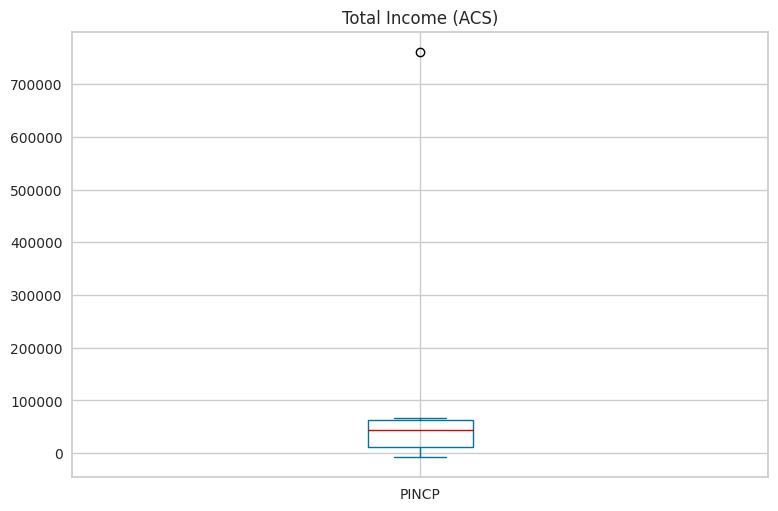

count      8788.000000
mean      50482.947656
std       62337.087800
min       -7300.000000
25%       13000.000000
50%       38000.000000
75%       66000.000000
max      761000.000000
Name: PINCP, dtype: float64

In [86]:
#Requirement 1, 5 number summary of total income variable 

acs.PINCP.describe() 

#it looks like we have some outliers in the subset,
# to be sure, lets visualize this 

acs.PINCP.describe().plot(kind='box',title='Total Income (ACS)')

plt.show()

#print 5 number under the visual 

acs.PINCP.describe()

In [87]:
pivot = acs.groupby('DOCC').PINCP.agg(avg_income = ('mean'),
                              median_income=('median'),
                              std_of_income=('std')).round()


pivot

#it looks like the average income is 
# MUCH higher for degree holders, as well as the median and std

pivot.T

DOCC,0,1
avg_income,27396.0,63529.0
median_income,19800.0,50000.0
std_of_income,36196.0,69789.0


In [88]:
perc = acs.query("WKHP > 35").shape[0] / acs.shape[0]

print(f'Percentage of People Working Full Time: {perc * 100:.2f}%')

Percentage of People Working Full Time: 64.71%


Part 2: Comparative Statistics 

• (10%) How many “major categories” are represented in the ACS data?


 For each “major category” calculate the proportion of
participants that have an occupation that requires a college degree. Do you notice any
patterns?


• (5%) What is the correlation between an individual’s age and their income? Choose a
visualization to demonstrate the relationship.



• (5%) What is the correlation between usual hours worked per week and income? Choose a
visualization to demonstrate the relationship.



• (10%) Calculate the z-scores of total income and the hours work per week variables. Comment
on the nature of any outliers.

In [89]:
#counting and listing distinct major categories 


#for this, lets join maj and acs on index (inner join and count distinct major category)

df2 = acs.join(maj,how='inner')

maj_list = df2.Major_Category.unique().tolist()

print(f'Distinct Major Cateogries: {maj_list}')

print(f'Number of Distinct Majors: {len(maj_list)}')

Distinct Major Cateogries: ['Biology & Life Science', 'Engineering', 'Education', 'Psychology & Social Work', 'Arts']
Number of Distinct Majors: 5


<Axes: title={'center': 'Proportion of Degree Holders by Major Category'}, ylabel='Major_Category'>

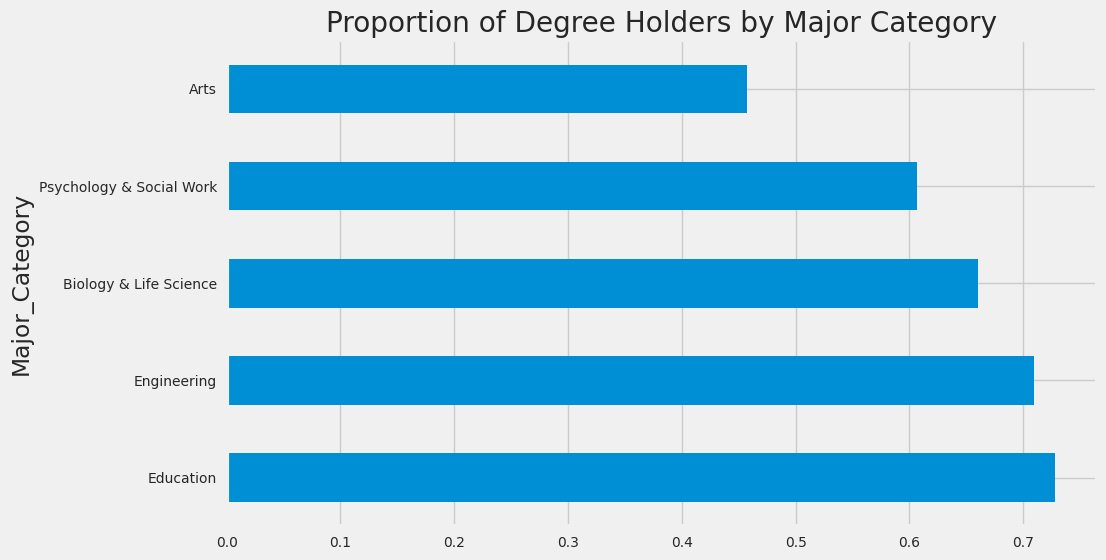

In [90]:
#finding proportion of degree holders by major category and visualize to analyze trend 

plt.style.use('fivethirtyeight')

df2.groupby('Major_Category')['DOCC'].mean()\
    .sort_values(ascending=False).plot(kind='barh',figsize=(10,6),title='Proportion of Degree Holders by Major Category')

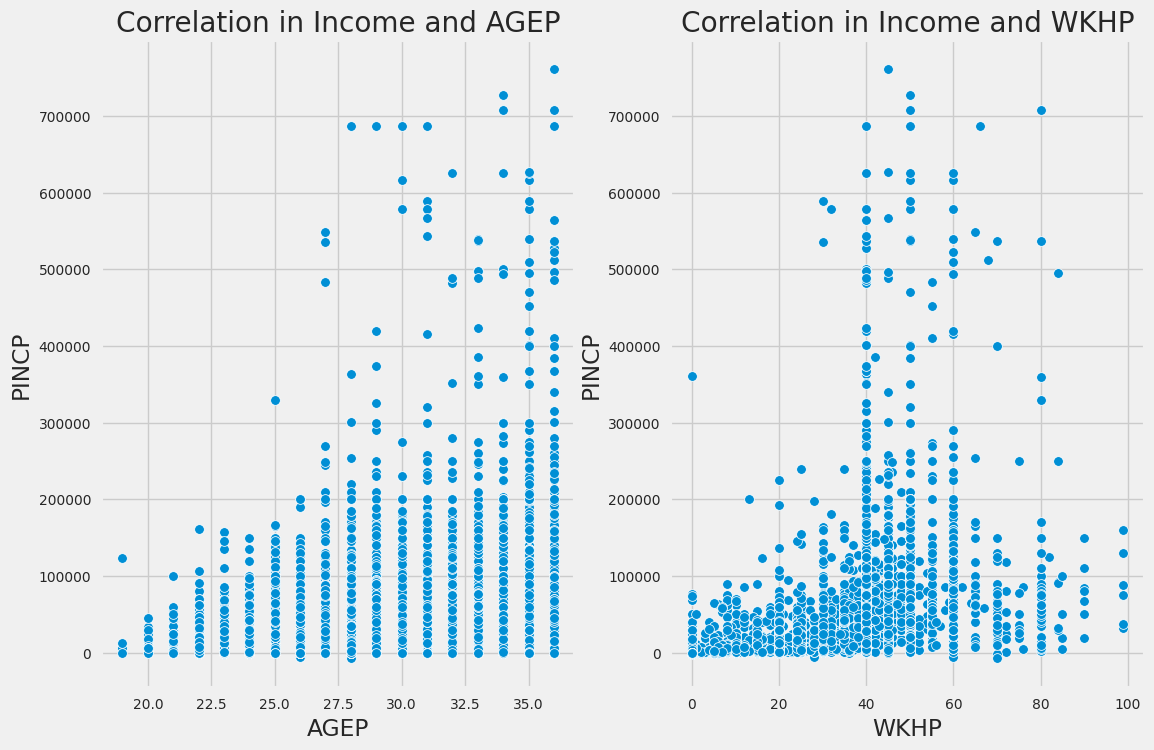

Correlation in Age and Income (Pearson): 0.31
Correlation in Hours Worked and Income (Pearson): 0.42


In [91]:
#correlation in age and income + visualize this relationship 

#correlation in hours worked and income + visualize this relationship 


age_corr = acs[['PINCP','AGEP']].corr().iloc[1,0].round(2)

hours_corr = acs[['WKHP','PINCP']].corr().iloc[1,0].round(2)

fig, ax = plt.subplots(ncols=2,figsize=(12,8))

corr_cols = ['AGEP','WKHP']

ax = ax.flatten()

for i, col in enumerate(corr_cols): 
    
    sns.scatterplot(acs, x=col,y='PINCP',ax=ax[i])
    
    ax[i].set_title(f'Correlation in Income and {col}')
    
plt.show()

print(f'Correlation in Age and Income (Pearson): {age_corr}')

print(f'Correlation in Hours Worked and Income (Pearson): {hours_corr}')

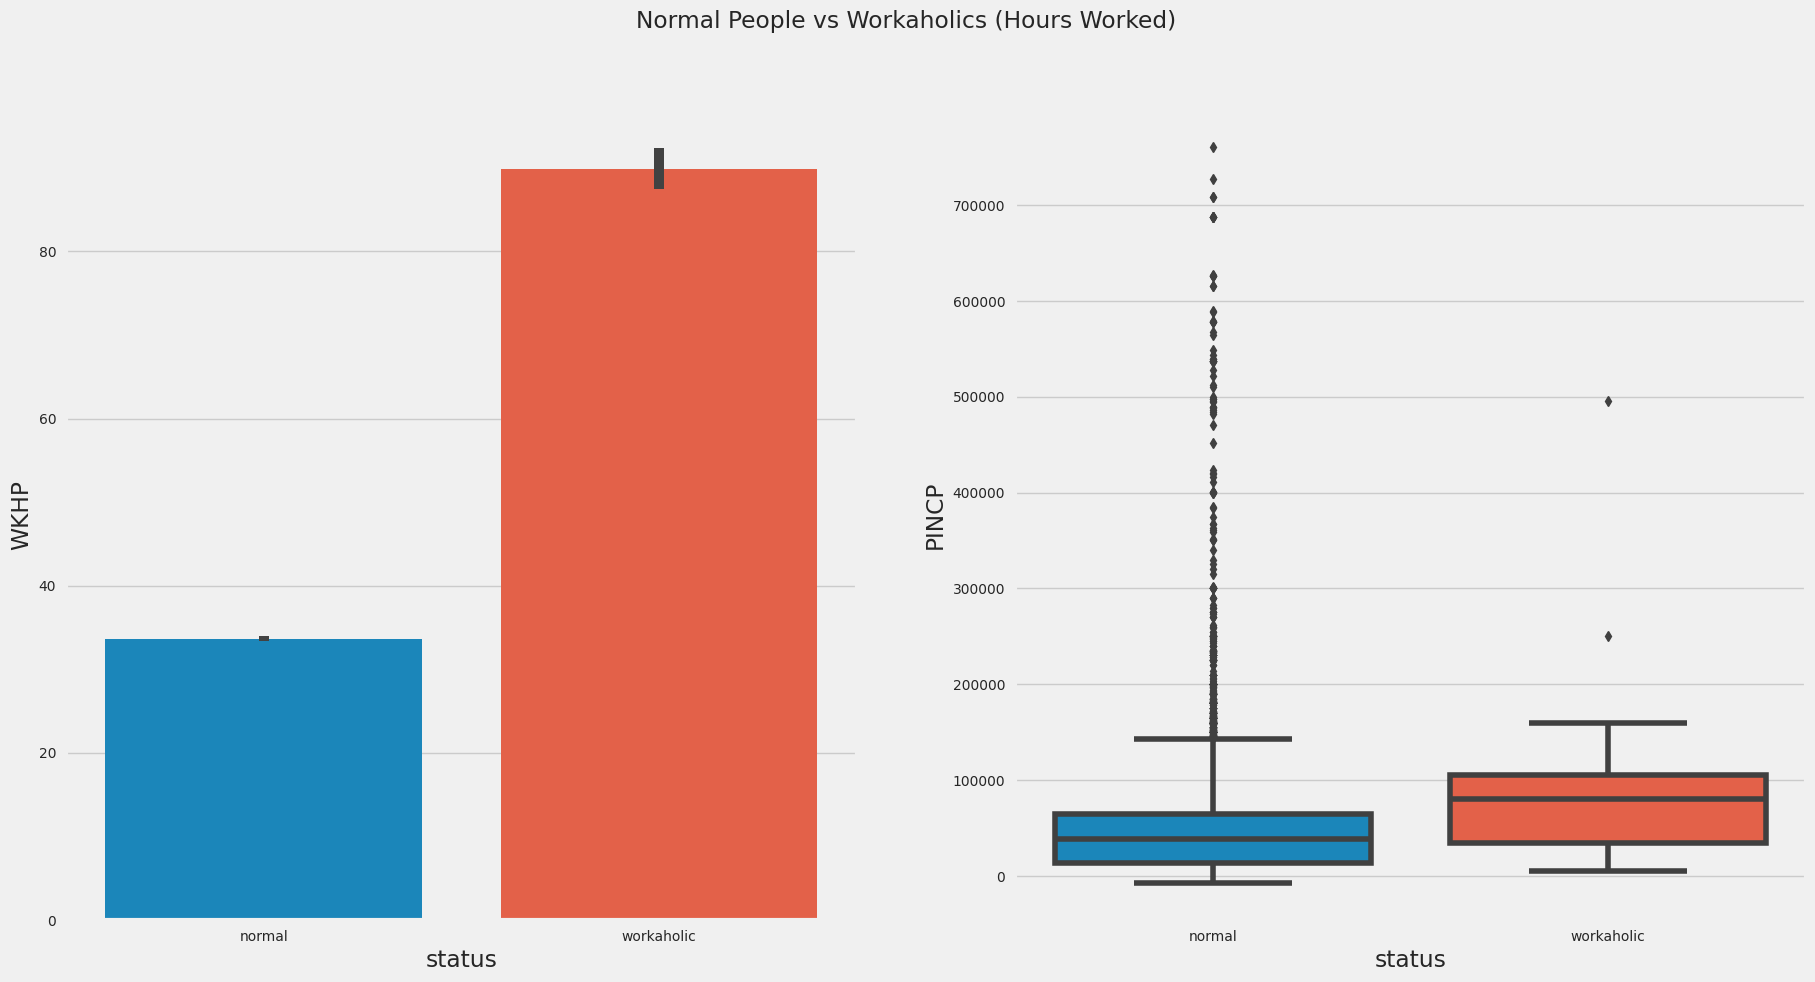

In [92]:
from scipy.stats import zscore 

acs = acs.assign(wkhp_z = zscore(acs['WKHP']),
           agep_z = zscore(acs['AGEP']))


out = (acs['wkhp_z'].abs() > 3) | (acs['agep_z'].abs() > 3)

outliers = acs.loc[out]


outliers.describe() 

#all of the outliers when examining the data are supposed to have worked 80-90hrs a week.... We can safely drop or impute these values

acs = acs.assign(status = np.where(out,'workaholic','normal'))

fig, ax = plt.subplots(ncols=2,figsize=(20,10))
fig.suptitle('Normal People vs Workaholics (Hours Worked)')

ax = ax.flatten()

sns.barplot(acs,x='status',y='WKHP',ax=ax[0])

sns.boxplot(acs,x='status',y='PINCP',ax=ax[1])

plt.show() 

#it looks like being a workaholic isn't always worth it! 

In [93]:
print(f'Percentage of Outliers: {round(acs[acs.status == "workaholic"].shape[0]/ acs.shape[0] * 100,2)}%')

#there are 23 outliers, given the relationship in income not being significant, we can drop these for this project. 

#using .loc subsetting 
acs = acs.loc[~out]

Percentage of Outliers: 0.26%


Part 3: Predictive Modeling (50%)

• (10%) Develop a logistic regression predictive model capable of predicting whether an
individual’s current occupation requires a college degree based on the following inputs.


o Major Category
o Level of Educational Attainment
o Usual hours worked per week


Provide a summary of this model.


• (5%) Discuss the accuracy of the model on the validation set.


• (15%) Build 3 alternative models and examine the accuracy on the validation data you created.


Did you find an alternative model that performed better than the logistic regression? 


Why should the committee trust your results?


• (5%) Apply your final predictive model to the Alumni Data set.


• (15%) Using your predictive model recommend a strategy for which alumni to contact first.

In [94]:
df = acs.join(maj,how='left')

df.Major.nunique()

#there are 76 distinct majors, nonetheless, lets preprocess and see if we can't identify any very important categories in a bonus section! 

#for now, drop major entirely and keep only major category 

76

In [95]:
#building out the dataset/feature space (first, lets look at the entire feature space)

#don't have much else to examing here. The "test set" is the alumni's data 

from sklearn.model_selection import train_test_split 

from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier

#define X and target. 

target = 'DOCC' 

#drop un-needed columns
clean_df = df.drop([target,'Major','status','WKHP','AGEP','WKWN'],axis=1)

X = pd.get_dummies(clean_df,columns=['Major_Category'],dtype=int)

y = df[[target]]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2)

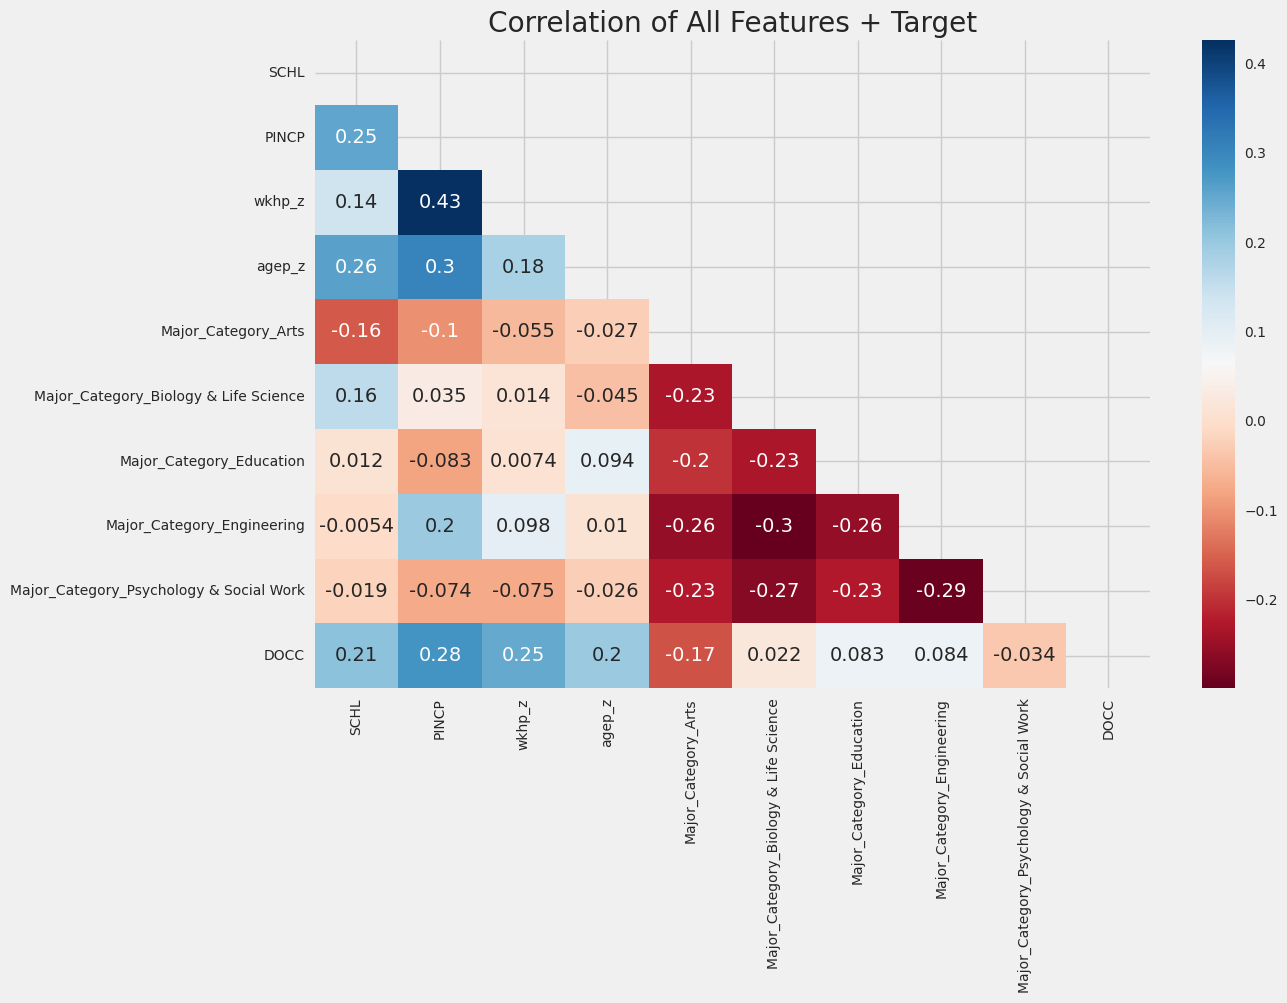

In [96]:
corr = pd.concat([X,y],axis=1).corr()

mask = np.triu(np.ones_like(corr))

plt.figure(figsize=(12,8))

sns.heatmap(corr,mask=mask, cmap='RdBu',annot=True)

plt.title('Correlation of All Features + Target') 

plt.show()

#speak on multi-colinearity and explain why univariate correlation is so important

In [97]:
#scale income variable and take some time to explain nominal vs ordinal categories, as well as how to preprocess 

from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler() 

X_train['PINCP'] = scaler.fit_transform(X_train[['PINCP']]) 

#we MUST preprocess features seperately in real ML use-cases. I followed project instructions but the project teaches this WRONG!!! (Data Leak)
X_test['PINCP'] = scaler.transform(X_test[['PINCP']])

In [98]:
#before modeling, we need to understand class balance, otherwise we can't understand performance 

df.DOCC.value_counts(normalize=True)

#this problem is fairly balanced, no classification will be 50/50! 

DOCC
1    0.638562
0    0.361438
Name: proportion, dtype: float64

In [99]:
#first, lets fit an logistic regression model and assess performance

from sklearn.metrics import classification_report, confusion_matrix

log = LogisticRegression(max_iter=1000)
#fit to train 
log.fit(X_train,y_train)
#predict
log_preds = log.predict(X_test)

#score 

report = classification_report(y_test,log_preds)


print(report)

matrix = confusion_matrix(y_test,log_preds)

print(matrix)


              precision    recall  f1-score   support

           0       0.64      0.49      0.55       641
           1       0.74      0.84      0.79      1112

    accuracy                           0.71      1753
   macro avg       0.69      0.66      0.67      1753
weighted avg       0.70      0.71      0.70      1753

[[314 327]
 [179 933]]


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Precision Explanation:
##the models success at predicting the outcome defined as TP/TP + FP
#this is useful in cases of minimizing false positives (MORE PRECISE IN ITS PREDICTION)
# Recall Explanation: 
#the models success at predicting outcome defined as TP / TP + FN
#this is useful for minimizing FALSE negative, we don't want to miss a true positive case. 

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


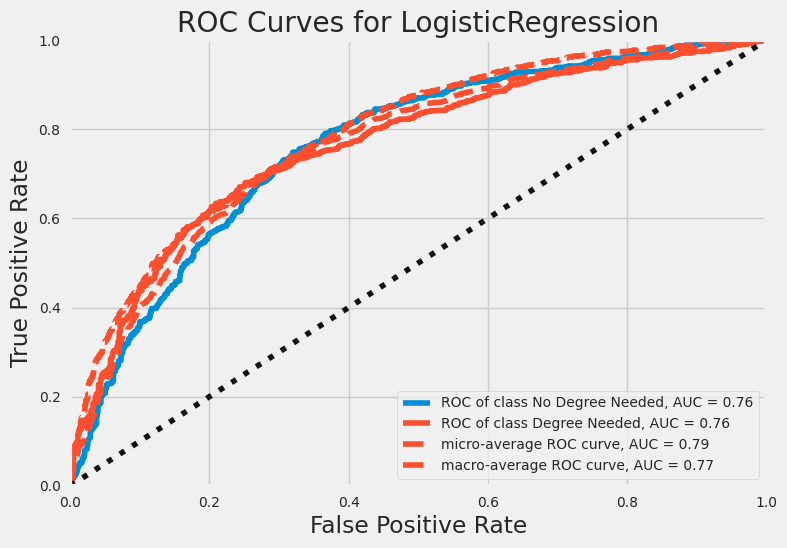

<Axes: title={'center': 'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [100]:
##Plotting ROC AUC 
# this allows us to see the relationship in true positive and false positive rate
# lets utilize yellowbrick for this 

from yellowbrick.classifier import ROCAUC

visualizer = ROCAUC(log,classes=['No Degree Needed','Degree Needed'])

visualizer.fit(X_train,y_train) 

visualizer.score(X_test,y_test) 

visualizer.show()

In [101]:
#lets try a 3rd and final model, then talk about tuning the latter 2 models. 

tree = DecisionTreeClassifier(max_depth=5) 

tree.fit(X_train,y_train) 

tree_preds = tree.predict(X_test)
 
report = classification_report(y_test,tree_preds)


print(report)

matrix = confusion_matrix(y_test,tree_preds)

print(matrix)

              precision    recall  f1-score   support

           0       0.62      0.60      0.61       641
           1       0.77      0.79      0.78      1112

    accuracy                           0.72      1753
   macro avg       0.70      0.69      0.70      1753
weighted avg       0.72      0.72      0.72      1753

[[383 258]
 [233 879]]


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


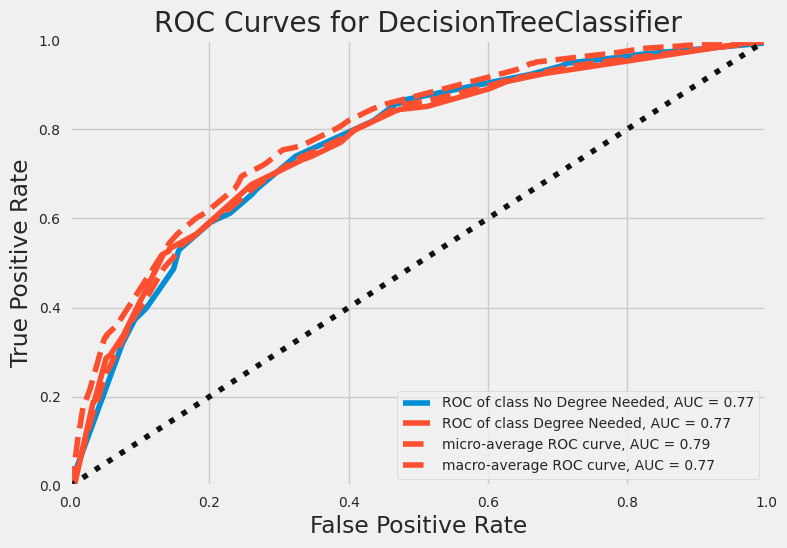

<Axes: title={'center': 'ROC Curves for DecisionTreeClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [102]:
visualizer = ROCAUC(tree,classes=['No Degree Needed','Degree Needed'])

visualizer.fit(X_train,y_train) 

visualizer.score(X_test,y_test) 

visualizer.show()

# it looks like our decision tree could outperform logreg with some tuning!

In [103]:
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV


tree_ = DecisionTreeClassifier()

params = {'criterion':['gini', 'entropy', 'log_loss'],
          'max_depth':np.arange(3,20,1), 
          'min_samples_split':np.arange(2,10,1)} 


tree_cv = GridSearchCV(tree_,params,
                             scoring='f1',
                             n_jobs=-1,
                             cv=3)

tree_cv.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
                         'min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9])},
             scoring='f1')

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from hyperopt import hp, tpe, fmin, Trials
from sklearn.metrics import f1_score


# Define hyperparameter search space
space = {
    'n_estimators': hp.choice('n_estimators', range(100, 1000)),
    'max_depth': hp.choice('max_depth', [None] + list(range(3, 21))),
    'min_samples_split': hp.uniform('min_samples_split', 0.1, 1.0),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0.1, 0.5),
    'bootstrap': hp.choice('bootstrap', [True, False])
}

# Define objective function
def objective(params):
    
    clf = RandomForestClassifier(**params, random_state=42)
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = f1_score(y_test, y_pred)
    return -accuracy  # Hyperopt minimizes the objective function, so we need to negate the metric

# Perform hyperparameter optimization
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

print("Best hyperparameters:", best)


  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/tmp/ipykernel_33/3055006630.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)



  2%|▏         | 1/50 [00:01<01:24,  1.73s/trial, best loss: -0.7762652705061082]

/tmp/ipykernel_33/3055006630.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)



  4%|▍         | 2/50 [00:03<01:24,  1.77s/trial, best loss: -0.7973602484472049]

/tmp/ipykernel_33/3055006630.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)



  6%|▌         | 3/50 [00:04<00:55,  1.18s/trial, best loss: -0.7973602484472049]

/tmp/ipykernel_33/3055006630.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)



  8%|▊         | 4/50 [00:06<01:16,  1.66s/trial, best loss: -0.7973602484472049]

/tmp/ipykernel_33/3055006630.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)



 10%|█         | 5/50 [00:08<01:29,  1.99s/trial, best loss: -0.7973602484472049]

/tmp/ipykernel_33/3055006630.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)



 12%|█▏        | 6/50 [00:11<01:31,  2.09s/trial, best loss: -0.7973602484472049]

/tmp/ipykernel_33/3055006630.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)



 14%|█▍        | 7/50 [00:13<01:29,  2.08s/trial, best loss: -0.7973602484472049]

/tmp/ipykernel_33/3055006630.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)



 16%|█▌        | 8/50 [00:14<01:20,  1.91s/trial, best loss: -0.7973602484472049]

/tmp/ipykernel_33/3055006630.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)



 18%|█▊        | 9/50 [00:16<01:16,  1.86s/trial, best loss: -0.7973602484472049]

/tmp/ipykernel_33/3055006630.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)



 20%|██        | 10/50 [00:17<00:57,  1.44s/trial, best loss: -0.7973602484472049]

/tmp/ipykernel_33/3055006630.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)



 22%|██▏       | 11/50 [00:17<00:45,  1.17s/trial, best loss: -0.7973602484472049]

/tmp/ipykernel_33/3055006630.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)



 24%|██▍       | 12/50 [00:18<00:44,  1.17s/trial, best loss: -0.7973602484472049]

/tmp/ipykernel_33/3055006630.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)



 26%|██▌       | 13/50 [00:19<00:37,  1.02s/trial, best loss: -0.7973602484472049]

/tmp/ipykernel_33/3055006630.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)



 28%|██▊       | 14/50 [00:20<00:31,  1.13trial/s, best loss: -0.7973602484472049]

/tmp/ipykernel_33/3055006630.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)



 30%|███       | 15/50 [00:22<00:42,  1.23s/trial, best loss: -0.7973602484472049]

/tmp/ipykernel_33/3055006630.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)



 32%|███▏      | 16/50 [00:23<00:48,  1.42s/trial, best loss: -0.7973602484472049]

/tmp/ipykernel_33/3055006630.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)



 34%|███▍      | 17/50 [00:26<00:53,  1.63s/trial, best loss: -0.7973602484472049]

/tmp/ipykernel_33/3055006630.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)



 36%|███▌      | 18/50 [00:28<00:58,  1.84s/trial, best loss: -0.7973602484472049]

/tmp/ipykernel_33/3055006630.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)



 38%|███▊      | 19/50 [00:30<01:00,  1.94s/trial, best loss: -0.7973602484472049]

/tmp/ipykernel_33/3055006630.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)



 40%|████      | 20/50 [00:31<00:46,  1.56s/trial, best loss: -0.7973602484472049]

/tmp/ipykernel_33/3055006630.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)



 42%|████▏     | 21/50 [00:32<00:41,  1.42s/trial, best loss: -0.7973602484472049]

/tmp/ipykernel_33/3055006630.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)



 44%|████▍     | 22/50 [00:33<00:36,  1.31s/trial, best loss: -0.7973602484472049]

/tmp/ipykernel_33/3055006630.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)



 46%|████▌     | 23/50 [00:35<00:40,  1.51s/trial, best loss: -0.7973602484472049]

/tmp/ipykernel_33/3055006630.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)



 48%|████▊     | 24/50 [00:38<00:49,  1.91s/trial, best loss: -0.7973602484472049]

/tmp/ipykernel_33/3055006630.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)



 50%|█████     | 25/50 [00:39<00:39,  1.58s/trial, best loss: -0.7973602484472049]

/tmp/ipykernel_33/3055006630.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)



 52%|█████▏    | 26/50 [00:39<00:30,  1.28s/trial, best loss: -0.7973602484472049]

/tmp/ipykernel_33/3055006630.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)



 54%|█████▍    | 27/50 [00:41<00:33,  1.47s/trial, best loss: -0.7973602484472049]

/tmp/ipykernel_33/3055006630.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)



 56%|█████▌    | 28/50 [00:42<00:28,  1.28s/trial, best loss: -0.7973602484472049]

/tmp/ipykernel_33/3055006630.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)



 58%|█████▊    | 29/50 [00:43<00:22,  1.09s/trial, best loss: -0.7973602484472049]

/tmp/ipykernel_33/3055006630.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)



 60%|██████    | 30/50 [00:44<00:25,  1.29s/trial, best loss: -0.7973602484472049]

/tmp/ipykernel_33/3055006630.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)



 62%|██████▏   | 31/50 [00:47<00:29,  1.57s/trial, best loss: -0.7973602484472049]

/tmp/ipykernel_33/3055006630.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)



In [ ]:
best_mod = RandomForestClassifier(**best) 

best_mod.max_depth = 10

visualizer = ROCAUC(best_mod,classes=['No Degree Needed','Degree Needed'])

visualizer.fit(X_train,y_train) 

visualizer.score(X_test,y_test) 

visualizer.show()